## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [3]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import math
import random

from matplotlib import pyplot as plt
from scipy.signal import find_peaks


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def LoadTroikaReferenceFile(ref_fl):
    """
    Loads and extracts signals from a troika ref data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        hr_refs = LoadTroikaReferenceFile(data_fls[0])

    Args:
        ref_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy array hr values.
    """
    hr_array = []
    data = sp.io.loadmat(ref_fl)
    for i in range(data['BPM0'].shape[0]):
        hr_array.append(data['BPM0'][i][0])
    
    return np.array(hr_array)


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, pass_band, fs=125):
    """
    Performs a bandpass filter on a signal

    Args:
        signal:  a numpy array containing a series of signal values.
        pass_band:  a tuple representing the target frequency range in hz (e.g. (1, 4))
        fs: the signal's sample rate in hz

    Returns:
        The filtered signal.
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)
    
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg_org, accx_org, accy_org, accz_org = LoadTroikaDataFile(data_fl)

    hr_refs = LoadTroikaReferenceFile(ref_fl)
    
    fs = 125
    secs = math.floor(ppg_org.shape[0]/fs)
    nfft = 8 * fs
    noverlap = 6 * fs
    hr_estimates = []
    errors = []
    confidence = []
    
    print(data_fl)
    last_hr_estimate = 0

    pass_band = (.67, 4)

    #get an 8 second window of data
    ppg = ppg_org
    accx = accx_org
    accx = BandpassFilter(accx, pass_band, fs)
    accy = accy_org
    accy = BandpassFilter(accy, pass_band, fs)
    accz = accz_org
    accz = BandpassFilter(accz, pass_band, fs)
    acc = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))
    
    #apply a bandpass filter
    filtered_ppg = BandpassFilter(ppg, pass_band, fs)  #bandpass range is between 60 and 240 bpm

    ppg_spectrum, ppg_freqs, times, ppg_image = plt.specgram(filtered_ppg, NFFT=nfft, Fs=fs, noverlap=noverlap)

    accx_spectrum, accx_freqs, timesx, accx_image = plt.specgram(accx, NFFT=nfft, Fs=fs, noverlap=noverlap)
    accy_spectrum, accy_freqs, timesy, accy_image = plt.specgram(accy, NFFT=nfft, Fs=fs, noverlap=noverlap)
    accz_spectrum, accz_freqs, timesz, accz_image = plt.specgram(accz, NFFT=nfft, Fs=fs, noverlap=noverlap)
    

    for i in range(len(times)):
        hr_ref = hr_refs[i]
        
        time = times[i]
        max_spec_indexes = np.flip(np.argsort(ppg_spectrum[:,i]))
        max_idx = max_spec_indexes[0]
        max_freq = ppg_freqs[max_idx]

        max_freqs = np.array([ ppg_freqs[max_spec_indexes[0]], ppg_freqs[max_spec_indexes[1]], ppg_freqs[max_spec_indexes[2]] ])
        max_hrs = 60 * max_freqs

        max_accx_freq = accx_freqs[np.argmax(accx_spectrum[:,i])]
        max_accy_freq = accy_freqs[np.argmax(accy_spectrum[:,i])]
        max_accz_freq = accz_freqs[np.argmax(accz_spectrum[:,i])]
        #print("time: {}, ppg_freq: {}, accx_freq: {}, accy_freqs: {}, accz_freq: {}, HRs: {}, hr_ref: {}".format(time, max_freqs, max_accx_freq, max_accy_freq, max_accz_freq, max_hrs, hr_ref))

        freq_diff = .15
        
        hr = max_freqs[0] * 60
        for i in range(0, 6):
            this_max_freq = ppg_freqs[max_spec_indexes[i]]
            if abs(this_max_freq - max_accx_freq) < freq_diff or abs(this_max_freq - max_accy_freq) < freq_diff or abs(this_max_freq - max_accz_freq) < freq_diff:
                continue
            else:
                hr = this_max_freq * 60   #13.686917360301289
                break
        
        hr_estimates.append(hr)

        errors.append(abs(hr - hr_ref))
        this_confidence = abs(1 / (hr - hr_ref)) ###################################  5.96046244164368
        confidence.append(this_confidence)


    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return np.array(errors), np.array(confidence)

./datasets/troika/training_data/DATA_01_TYPE01.mat
./datasets/troika/training_data/DATA_02_TYPE02.mat
./datasets/troika/training_data/DATA_03_TYPE02.mat
./datasets/troika/training_data/DATA_04_TYPE01.mat
./datasets/troika/training_data/DATA_04_TYPE02.mat
./datasets/troika/training_data/DATA_05_TYPE02.mat
./datasets/troika/training_data/DATA_06_TYPE02.mat
./datasets/troika/training_data/DATA_07_TYPE02.mat


/home/nathan/anaconda3/envs/ds_for_wearables/lib/python3.7/site-packages/ipykernel_launcher.py:200: RuntimeWarning: divide by zero encountered in double_scalars


./datasets/troika/training_data/DATA_08_TYPE02.mat
./datasets/troika/training_data/DATA_10_TYPE02.mat
./datasets/troika/training_data/DATA_11_TYPE02.mat
./datasets/troika/training_data/DATA_12_TYPE02.mat
5.96046244164368


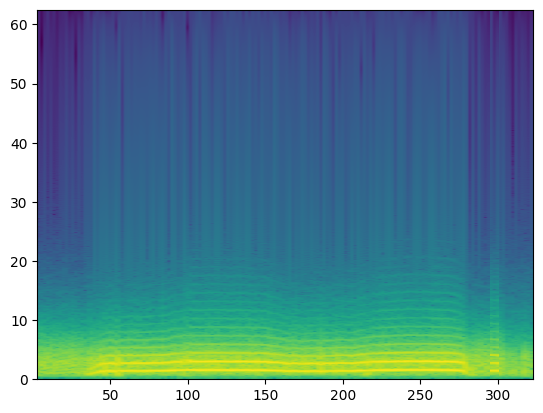

In [4]:
# data_files, reference_files = LoadTroikaDataset()
# for data_fl, ref_fl in zip(data_files, reference_files):
#     errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
#     print(errors, confidence)

print(Evaluate())

In [ ]:
data_files, reference_files = LoadTroikaDataset()
#print(data_files)
#print(reference_files)

data_file = data_files[0]
print("loading: ", data_file)
sig_data = LoadTroikaDataFile(data_file)
ppg, accx, accy, accz = LoadTroikaDataFile(data_file)
acc_total = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))

fs = 125  
pass_band = (.67, 4)
ts = np.arange(len(accx)) / fs
nfft = fs*8  #The number of data points used in each block for the FFT.
noverlap = fs*6  #The number of points of overlap between blocks.

filtered_ppg = BandpassFilter(ppg, pass_band, fs)
ppg_spectrum, ppg_freqs, times, ppg_image = plt.specgram(filtered_ppg, NFFT = nfft, Fs=fs, noverlap=noverlap)
print("ppg_spectrum.shape: " , ppg_spectrum.shape)
print("ppg_freqs.shape: " , ppg_freqs.shape)
print("times.shape: " , times.shape)

print("ppg_freqs[:10]: " , ppg_freqs[:10])


for i in range(len(times)):
    time = times[i]
    max_idx = np.argmax(ppg_spectrum[:,i])
    max_freq = ppg_freqs[max_idx]
    #print("time: {}, freq: {}, HR: {}".format(time, max_freq, max_freq*60))

# print(ppg_spectrum[:,10])
# max_idx = np.argmax(ppg_spectrim[:,10])
# print(ppg_freqs[max_idx])


loading:  ./datasets/troika/training_data/DATA_01_TYPE01.mat
(1000,)
(1000,)
(1000,)


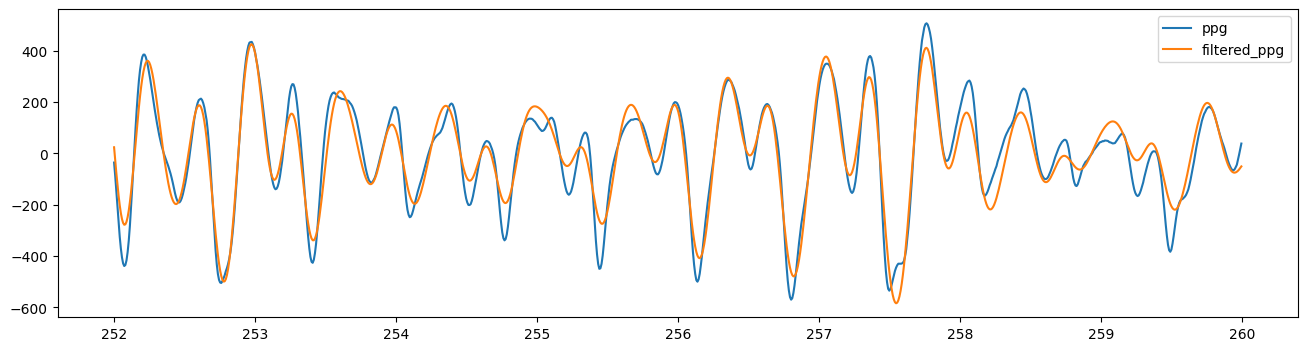

In [5]:
# *************************************************
data_file = data_files[0]
print("loading: ", data_file)
sig_data = LoadTroikaDataFile(data_file)
ppg, accx, accy, accz = LoadTroikaDataFile(data_file)

#grab an 8 second time window 
begin_second = 252
begin_idx = begin_second*fs
end_idx = (8+begin_second)*fs

ppg = ppg[begin_idx:end_idx]
accx = accx[begin_idx:end_idx]
accy = accy[begin_idx:end_idx]
accz = accz[begin_idx:end_idx]

acc_total = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))

filtered_ppg = BandpassFilter(ppg, (.67, 4), fs)  #bandpass range is between 40 and 240 bpm

print(ts[begin_idx:end_idx].shape)
print(ppg.shape)
print(filtered_ppg.shape)

plt.figure(figsize=(16, 4))
plt.plot(ts[begin_idx:end_idx],          ppg, label='ppg')
plt.plot(ts[begin_idx:end_idx], filtered_ppg, label='filtered_ppg')
plt.legend()

loading:  ./datasets/troika/training_data/DATA_01_TYPE01.mat


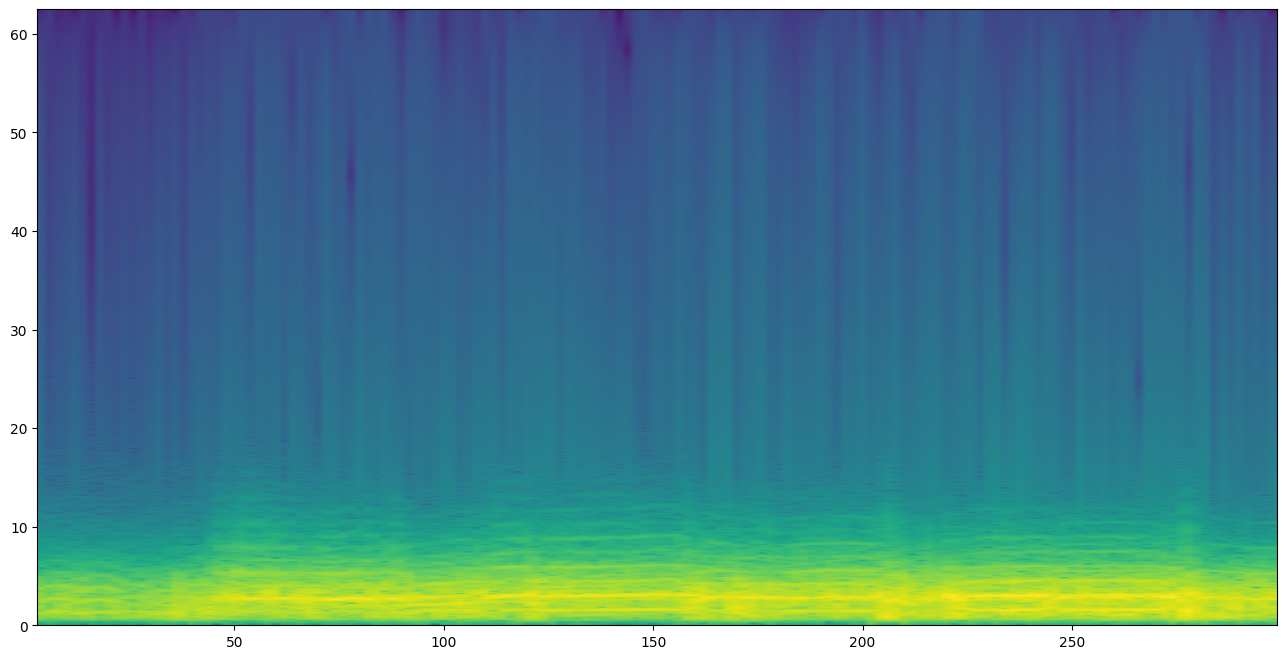

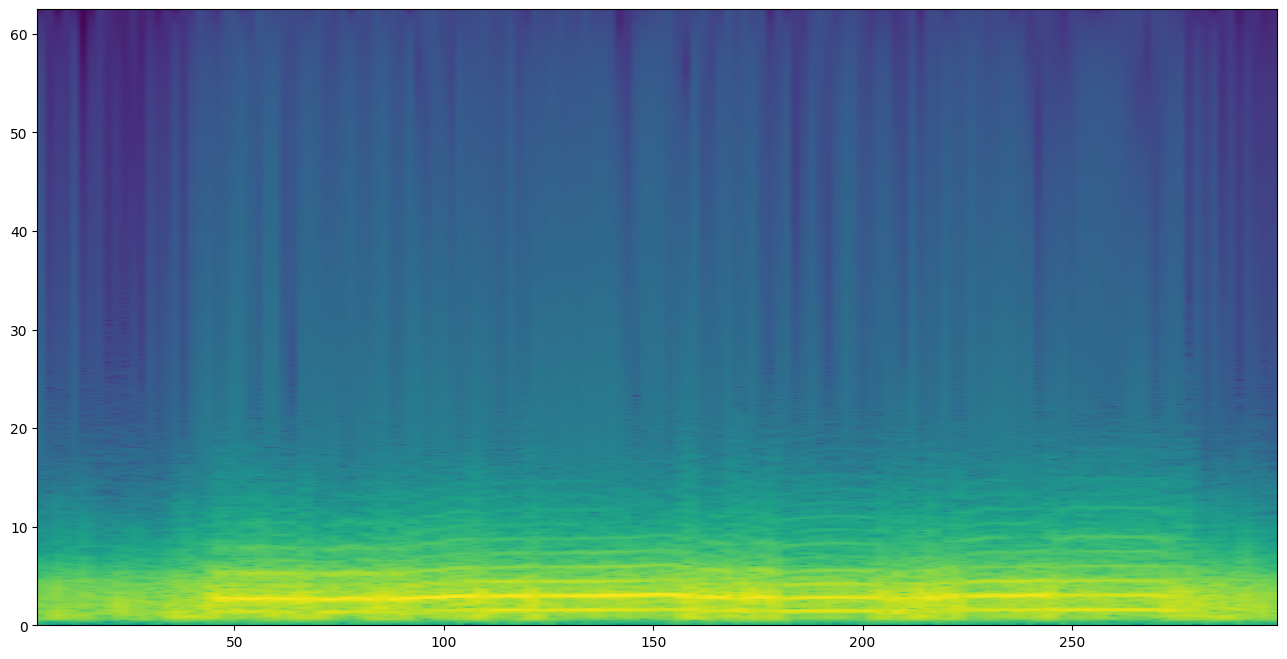

In [20]:
#apply fft to determine HR
data_file = data_files[0]
print("loading: ", data_file)
sig_data = LoadTroikaDataFile(data_file)
ppg, accx, accy, accz = LoadTroikaDataFile(data_file)

filtered_ppg = BandpassFilter(ppg, (.67, 4), fs)  #bandpass range is between 40 and 240 bpm
filtered_accy = BandpassFilter(accy, (.67, 4), fs)  #bandpass range is between 40 and 240 bpm

plt.figure(figsize=(16,8))
plt.specgram(filtered_ppg, Fs=fs, NFFT=fs*8, noverlap=fs*6);
plt.show()

plt.figure(figsize=(16,8))
plt.specgram(filtered_accy, Fs=fs, NFFT=fs*8, noverlap=fs*6);
plt.show()


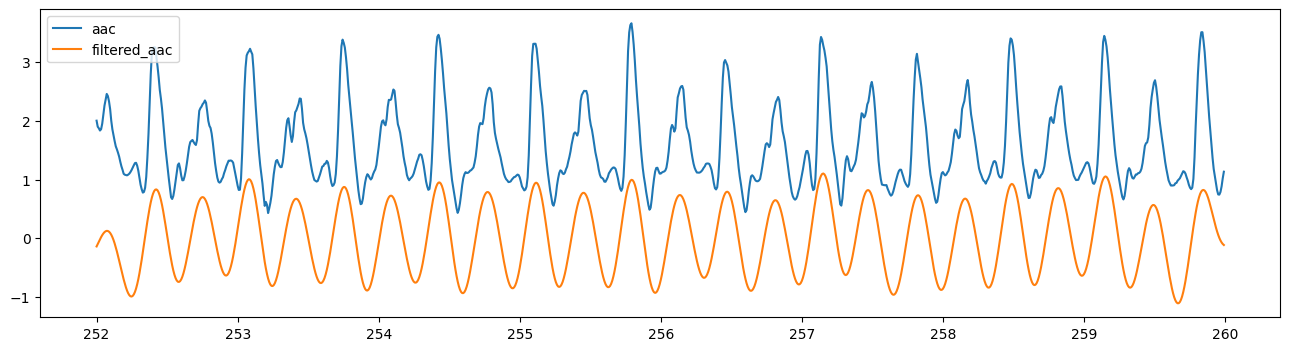

In [328]:
filtered_acc_total = BandpassFilter(acc_total, (.5, 4), fs)  #bandpass range is between 30 and 240 bpm

plt.figure(figsize=(16, 4))
plt.plot(ts[begin_idx:end_idx],          acc_total, label='aac')
plt.plot(ts[begin_idx:end_idx], filtered_acc_total, label='filtered_aac')
plt.legend()

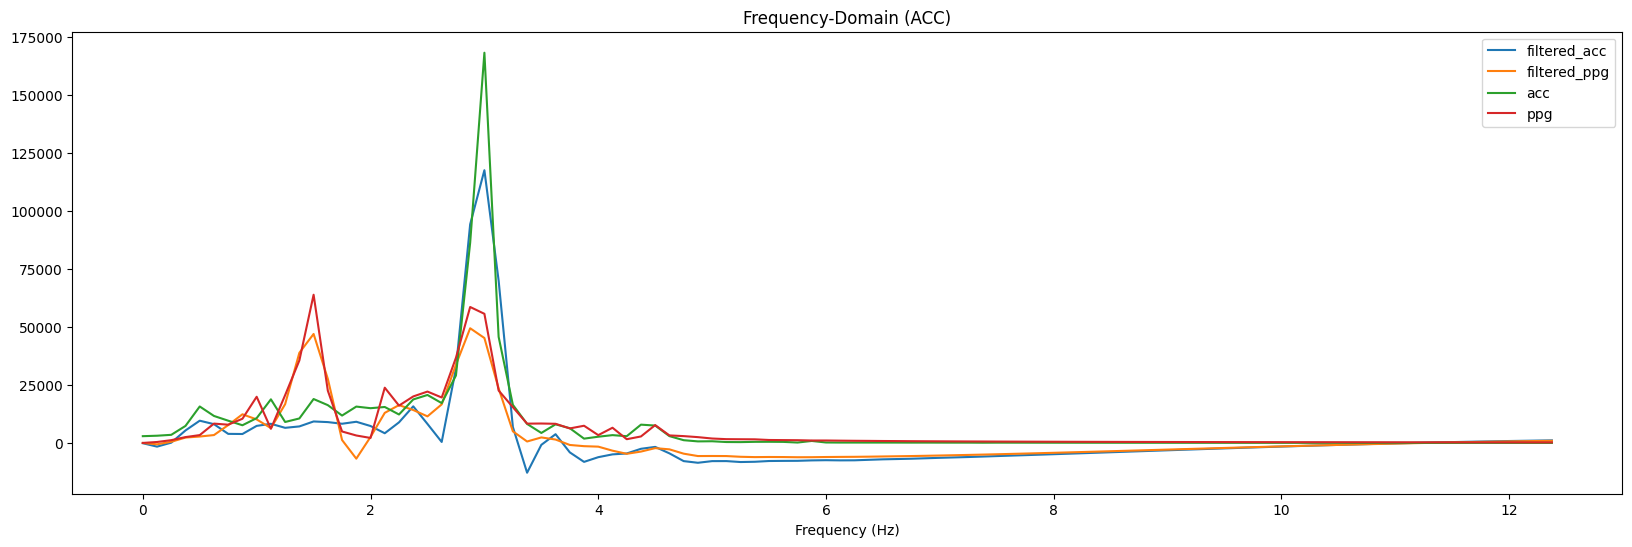

In [329]:
#apply fft to determine frequencies that may interfere with HR PPG measurement

freqs_acc = np.fft.rfftfreq(len(filtered_acc_total), 1/fs)    # rfftfreq tells us the frequencies for which we are computing the Fourier transform.
fft_acc   = np.fft.rfft(filtered_acc_total)                     # rfft computes the actual Fourier transform coefficients

filtered_fft_acc = BandpassFilter(np.abs(fft_acc), (1, 32), fs)  #bandpass range is between 30 and 240 bpm
filtered_fft_ppg = BandpassFilter(np.abs(fft_ppg), (1, 32), fs)  #bandpass range is between 30 and 240 bpm

plt.figure(figsize=(20, 6))
plt.plot(freqs_acc[0:100], 500*filtered_fft_acc[0:100], label='filtered_acc')
plt.plot(freqs_ppg[0:100], filtered_fft_ppg[0:100], label='filtered_ppg')
plt.plot(freqs_acc[0:100], 500*np.abs(fft_acc)[0:100], label='acc')
plt.plot(freqs_ppg[0:100], np.abs(fft_ppg)[0:100], label='ppg')
plt.title('Frequency-Domain (ACC)')
plt.xlabel('Frequency (Hz)')
plt.legend()

peak ppg indices [ 5 12 17 23 28 36 48]
peak ppg magnitudes [ 3453.35955067 47041.68956347 13027.17937569 49501.87130852
  2429.67193592 -2182.65532823 -6011.64779132]
peak ppg frequencies [0.625 1.5   2.125 2.875 3.5   4.5   6.   ]
peak acc indices [ 4 12 17 24 29 35 40 47 52 58]
peak acc magnitudes [ 19.29228851  18.63444672   8.4666582  235.29192916   7.63997185
  -4.93703991 -15.56825011 -14.94333263 -14.01973532 -12.03007178]
peak acc frequencies [0.5   1.5   2.125 3.    3.625 4.375 5.    5.875 6.5   7.25 ]


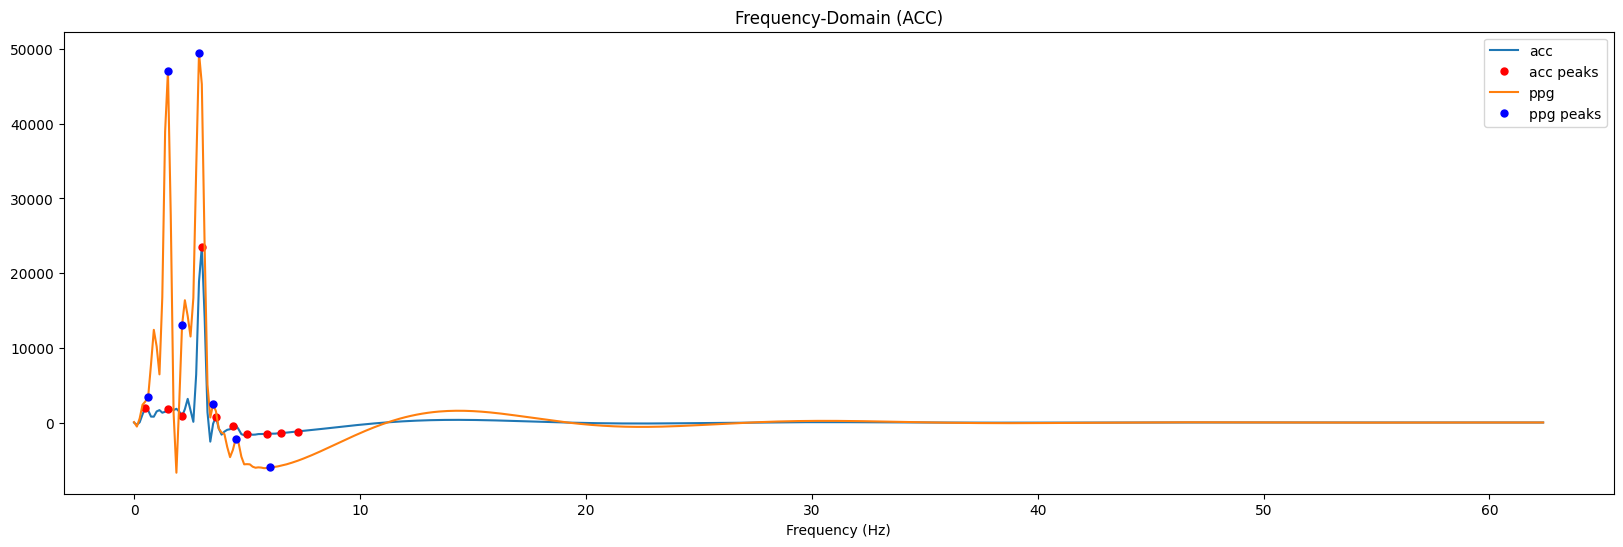

In [335]:
from scipy.signal import find_peaks
# acc_peaks = find_peaks(filtered_fft_acc, height = 0, threshold = None, distance = 25)
# ppg_peaks = find_peaks(filtered_fft_ppg, height = 0, threshold = None, distance = 25)
acc_peaks = find_peaks(np.abs(fft_acc), height = 0, threshold = None, distance = 5)
ppg_peaks = find_peaks(np.abs(fft_ppg), height = 0, threshold = None, distance = 5)

#print("acc_peaks", acc_peaks)
print("peak ppg indices", ppg_peaks[0])
print("peak ppg magnitudes", filtered_fft_ppg[ppg_peaks[0]])
print("peak ppg frequencies", freqs_ppg[ppg_peaks[0]])
print("peak acc indices", acc_peaks[0])
print("peak acc magnitudes", filtered_fft_acc[acc_peaks[0]])
print("peak acc frequencies", freqs_acc[acc_peaks[0]])

plt.figure(figsize=(20, 6))
plt.plot(freqs_acc[0:500], filtered_fft_acc[0:500]*100, label='acc')
plt.plot(freqs_acc[acc_peaks[0]], filtered_fft_acc[acc_peaks[0]]*100, 'r.', ms=10, label='acc peaks')

plt.plot(freqs_ppg[0:500], filtered_fft_ppg[0:500], label='ppg')
plt.plot(freqs_ppg[ppg_peaks[0]], filtered_fft_ppg[ppg_peaks[0]], 'b.', ms=10, label='ppg peaks')
plt.title('Frequency-Domain (ACC)')
plt.xlabel('Frequency (Hz)')
plt.legend()

In [336]:
#The top indices of the ppg sensor
sorted_top_ppg_peak_values = np.argsort(filtered_fft_ppg[ppg_peaks[0]]) 

top_ppg_peak_magnitudes = np.flip(filtered_fft_ppg[ppg_peaks[0]][sorted_top_ppg_peak_values])
top_ppg_peak_frequencies = np.flip(freqs_ppg[ppg_peaks[0]][sorted_top_ppg_peak_values])

#print("top_acc_peak_magnitudes", top_acc_peak_magnitudes)
print("top_ppg_peak_frequencies", top_ppg_peak_frequencies)

hr = 60 * top_ppg_peak_frequencies[0]
print("hr (min): ", hr * .85)
print("hr: ", hr)
print("hr (max): ", hr * 1.15)


top_ppg_peak_frequencies [2.875 1.5   2.125 0.625 3.5   4.5   6.   ]
hr (min):  146.625
hr:  172.5
hr (max):  198.37499999999997


In [312]:
def FindPeaks(signal, order=10):
    """A simple peak detection algorithm."""
    msk = (signal[order:-order] > signal[:-order * 2]) & (signal[order:-order] > signal[order * 2:])
    for o in range(1, order):
        msk &= (signal[order:-order] > signal[o: -order * 2 + o])
        msk &= (signal[order:-order] > signal[order * 2 - o: -o])
    return msk.nonzero()[0] + order

print(FindPeaks(filtered_fft_acc[0:1500], order=100))

[]


In [313]:
#The task - find the peak (blue dot in the chart above) that does not have a corresponding acc peak (top 3 red dots)

#The top indices of the acc sensor
sorted_top_acc_peak_values = np.argsort(filtered_fft_acc[acc_peaks[0]]) 

top_acc_peak_magnitudes = np.flip(filtered_fft_acc[acc_peaks[0]][sorted_top_acc_peak_values])
top_acc_peak_frequencies = np.flip(freqs_acc[acc_peaks[0]][sorted_top_acc_peak_values])

#print("top_acc_peak_magnitudes", top_acc_peak_magnitudes)
print("top_acc_peak_frequencies", top_acc_peak_frequencies)

#The top indices of the ppg sensor
sorted_top_ppg_peak_values = np.argsort(filtered_fft_ppg[ppg_peaks[0]]) 

top_ppg_peak_magnitudes = np.flip(filtered_fft_ppg[ppg_peaks[0]][sorted_top_ppg_peak_values])
top_ppg_peak_frequencies = np.flip(freqs_ppg[ppg_peaks[0]][sorted_top_ppg_peak_values])

#print("top_ppg_peak_magnitudes", top_ppg_peak_magnitudes)
print("top_ppg_peak_frequencies", top_ppg_peak_frequencies)

def find_hr_freq_from_ppg_and_acc(top_ppg_peak_frequencies, top_acc_peak_frequencies):
    hr_freq = 0
    for ppg_freq in top_ppg_peak_frequencies:
        print("testing ppg_freq:", ppg_freq)
        counter = 0
        skip_ppg_freq = False
        for aac_freq in top_acc_peak_frequencies:
            counter += 1
            if counter > 3:
                break
            if ppg_freq > aac_freq*.94 and ppg_freq < aac_freq*1.07:
                skip_ppg_freq = True
        if not skip_ppg_freq:
            hr_freq = ppg_freq
            break

    return hr_freq

hr_freq = find_hr_freq_from_ppg_and_acc(top_ppg_peak_frequencies, top_acc_peak_frequencies)
hr_bpm = hr_freq * 60
print("hr_freq = {}, hr_bpm = {}".format(hr_freq, hr_bpm))
            
            



top_acc_peak_frequencies [2.875 7.375]
top_ppg_peak_frequencies [2.875 6.625]
testing ppg_freq: 2.875
testing ppg_freq: 6.625
hr_freq = 6.625, hr_bpm = 397.5


In [287]:
data_files, reference_files = LoadTroikaDataset()
#print(data_files)
#print(reference_files)

data_file = reference_files[1]
print("loading: ", data_file)
ref_data = sp.io.loadmat(data_file)
print(ref_data)

loading:  ./datasets/troika/training_data/REF_02_TYPE02.mat
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 12 01:06:15 2014', '__version__': '1.0', '__globals__': [], 'BPM0': array([[ 84.74576271],
       [ 89.77149075],
       [ 92.59259259],
       [ 88.99676375],
       [ 84.36445444],
       [ 81.2567714 ],
       [ 76.09921082],
       [ 72.90400972],
       [ 72.11538462],
       [ 70.92198582],
       [ 74.58563536],
       [ 76.79180887],
       [ 73.932092  ],
       [ 73.05194805],
       [ 71.77033493],
       [ 69.51596292],
       [ 73.44940152],
       [ 78.04370447],
       [ 84.35582822],
       [ 90.75907591],
       [ 93.53741497],
       [ 94.82758621],
       [ 96.35974304],
       [ 97.2972973 ],
       [ 98.68421053],
       [101.14107884],
       [103.68663594],
       [104.83870968],
       [104.95156082],
       [104.05549626],
       [103.83386581],
       [103.39342524],
       [103.39342524],
       [103.32950631],
       [103.2

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

## Code Description 
I tried to stick with the starter code.  The first cell contains all of the code necessary to extract the information from teh files, interpret the PPG and ACC data, and produce that output necessary to allow the evaluate method to run.

The second cell runs the Evaluate() method and displays the results.  

The subsequent cells contain the steps I peformed to come up with the algorithim to determine the HR.  I needed to display several charts to see how the data was being processed and how to extract meaningful results form the PPG and ACC signal data.

## Data Description 
The data includes the output from a PGG sensor and a 3-axis accelerometer.  When the patients started to exercise, the body motion introduced noise in teh PPG sensor's data.  Of course, a sensor that porducted data this is not as influenced by body motion would help. In addition, data from an ECG sensor would help as well to have an additional source of HR data.


## Algorithim Description 
The following steps produce the data for the project:
 - The algorithim first reads the data file and creates numpy arrays of the PPG sensor's output and the 3-axis accelerometer.  The y-axis of the accelerometer produced the most useful results.
 - A bandpass filter was applied to both signals to remove noise that is ouside of the range of data we are interested in (less than 40 BPM, more than 240 BPM)
 - A fast fourier transform (FFT) is ran against both signals to ouptu the data into the frequency domain.
 - The peaks of the FFT are recorded and sorted from highest to lowest.
 - The peak frequency from the PPG sensor is considered to the the heart rate
 - It seems that motions picked up by the AAC sensor can often interfere with the PPG sensor,  If the HR identified by the PPG sensor is equal to the second highest frequence of the AAC sensor, theh the second highest frequency pean from the PPG sensor is most likely and correct frequency.  (this was determined with trial-and-error)
 - A confidence level is determined.  The greater the difference between the highest and second highest PPG frequency correlates to the confidence level.
 - The error and condfidence levels are added to arrays to return for evaluation.

The algorithim tends to do well before the patient starts moving and body motion is limited.  Once the patient starts exercising, body motions increase and the accuracy of the HR algorithim decreases.  Sometimes that motion interferes with the HR and sometimes the HR and motions match, so it is hard to tell when the patient's motions are constructive or destructively interfereing with the PPG HR sensor.


## Algorithm Performance
The performance of the algorithim was evaluated by computing the difference between the algorithim's output and the labels provided in the data.  Users of the algorithim would be interested in knowing a range of heart rates that fall within within a 95% confidence level of the algorithim's output.  The bigger the range, the less confident the user can be of the device's output.  




-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 